In [37]:
# Config -- A DONNER AUX ETUDIANTS
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

import random, numpy as np, tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef
import matplotlib.pyplot as plt


SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR = "dataset_224"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR   = os.path.join(DATA_DIR, "validation")
TEST_DIR  = os.path.join(DATA_DIR, "test")

IMG_SIZE = (224, 224)
IMG_SHAPE = (224, 224, 3)
BATCH_SIZE = 32
NUM_CLASSES = 3
AUTOTUNE = tf.data.AUTOTUNE

In [38]:
# Recuperation  des donnees. -- QUESTION 1: RECUPEREZ LES DONNEES DU DIRECTORY DATASET DANS TROIS VARIABLES DISTINCTES : TRAIN_DS, VAL_DS, TEST_DS
train_ds = keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
)

val_ds = keras.utils.image_dataset_from_directory(
    VAL_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
)

test_ds = keras.utils.image_dataset_from_directory(
    TEST_DIR,
    labels="inferred",
    label_mode="int",
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
)

class_names = train_ds.class_names
class_names

Found 630 files belonging to 3 classes.
Found 60 files belonging to 3 classes.
Found 150 files belonging to 3 classes.


['Healthy', 'Powdery', 'Rust']

In [ ]:
# Rescaling/autotuning -- A DONNER ? OU A EXPLIQUER PENDANT LE TP :
# LE RESCALING PERMET DE CONVERTIR LES PIXELS ENTRE 0 ET 255 EN VALEURS ENTRE 0 ET 1 POUR FACILITER L'APRENTISSAGE DU MODELE,
# .CACHE().PREFETCH(AUTOTUNE) SERT A OPTIMISER LA VITESSE AUTOMATIQUEMENT : LE DATASET EST MEMORISER EN RAM APRES LA PREMIERE LECTURE
# ET LES BATCHS SUIVANT SONT PRECHARGER PENDANT QUE LE MODELE S'ENTRAINTE SUR LE BATCH ACTUEL. 
rescale = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)
val_ds   = val_ds.map(lambda x, y: (rescale(x), y),   num_parallel_calls=AUTOTUNE)
test_ds  = test_ds.map(lambda x, y: (rescale(x), y),  num_parallel_calls=AUTOTUNE)

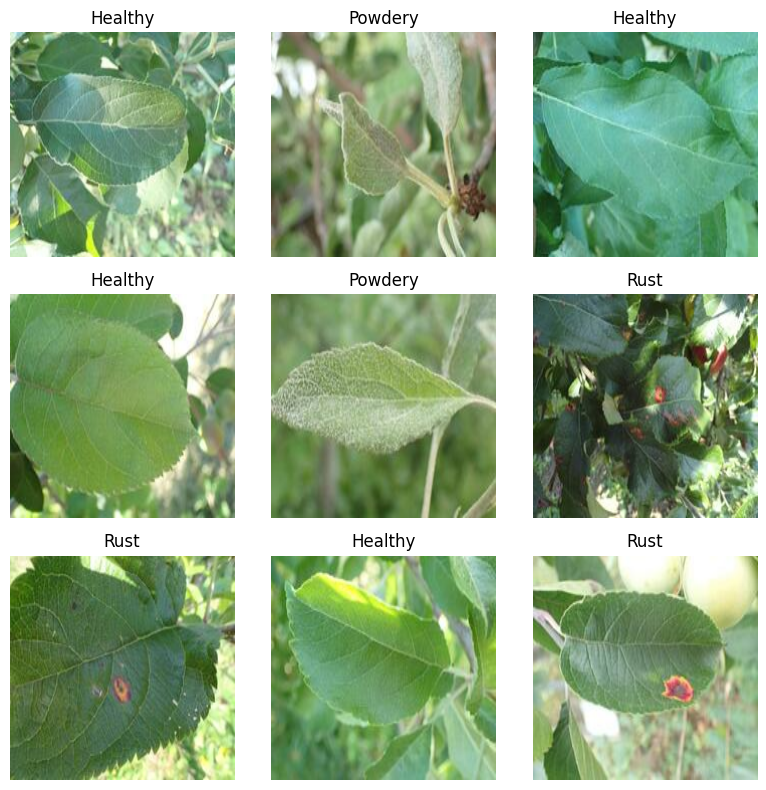

In [40]:
# Visualisation d'un sample -- QUESTION 2 : ECRIVEZ UNE FONCTION AFIN D'AFFICHER UN SAMPLE DE 9 IMAGES DE NOTRE DATASET
def show_batch(dataset, class_names, max_images=9):
    images, labels = next(iter(dataset))
    plt.figure(figsize=(8, 8))
    for i in range(min(max_images, images.shape[0])):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")
    plt.tight_layout()

show_batch(train_ds, class_names)

In [41]:
# construction du MLP  -- QUESTION 3 : CONSTRUISEZ UN PREMIER RESEAU DE NEURONES CLASSIQUE (MLP) EN UTILISANT LE MODULE KERAS, COMPRENANT DEUX COUCHES CACHEES ET
# UNE COUCHE DE SORTIE. LES COUCHES CACHEES UTILISERONS LA FONCTION D'ACTIVATION RELU, ET CELLE DE SORTIE, LA FONCTION SOFTMAX. COMPILEZ VOTRE MODELE.
def build_mlp(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = layers.Flatten()(inputs)
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs, name="mlp_baseline")
    return model

mlp = build_mlp(IMG_SHAPE, NUM_CLASSES)
mlp.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"],
)
mlp.summary()

Model: "mlp_baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    77,070,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 77,202,947 (294.51 MB)

 Trainable params: 77,202,947 (294.51 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
# training MLP -- QUESTION 4 : LANCEZ L'ENTRAINEMENT DE VOTRE MODELE EN PENSANT A SAUVEGARDER L'HISTORIQUE POUR LA SUITE DU TP.
# VOUS POUVEZ PARAMETRER DES CALLBACKS SI NECESSAIRE.
early_stop = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=4, restore_best_weights=True
)

history_mlp = mlp.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stop],
    verbose=2
)

Epoch 1/20
20/20 - 8s - 421ms/step - accuracy: 0.3524 - loss: 68.7648 - val_accuracy: 0.3333 - val_loss: 48.7893
Epoch 2/20
20/20 - 7s - 347ms/step - accuracy: 0.3937 - loss: 16.9928 - val_accuracy: 0.4667 - val_loss: 3.0515
Epoch 3/20
20/20 - 7s - 348ms/step - accuracy: 0.4667 - loss: 2.9627 - val_accuracy: 0.4833 - val_loss: 1.0042
Epoch 4/20
20/20 - 7s - 341ms/step - accuracy: 0.5143 - loss: 1.0458 - val_accuracy: 0.4000 - val_loss: 1.0772
Epoch 5/20
20/20 - 7s - 339ms/step - accuracy: 0.4968 - loss: 0.9742 - val_accuracy: 0.5333 - val_loss: 1.0411
Epoch 6/20
20/20 - 7s - 345ms/step - accuracy: 0.5889 - loss: 0.8963 - val_accuracy: 0.6167 - val_loss: 0.9825
Epoch 7/20
20/20 - 7s - 339ms/step - accuracy: 0.4397 - loss: 1.0175 - val_accuracy: 0.4667 - val_loss: 1.0188
Epoch 8/20
20/20 - 7s - 338ms/step - accuracy: 0.4810 - loss: 1.0021 - val_accuracy: 0.4167 - val_loss: 1.0282
Epoch 9/20
20/20 - 7s - 340ms/step - accuracy: 0.4937 - loss: 1.0223 - val_accuracy: 0.4000 - val_loss: 1.072

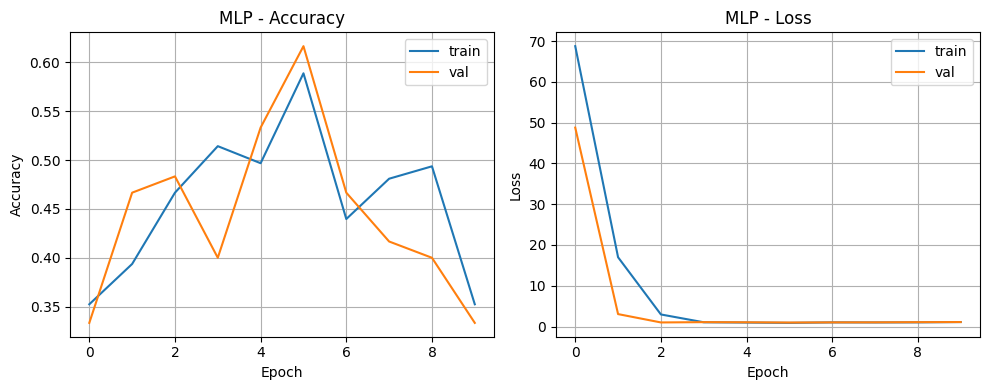

In [43]:
# learning curves -- QUESTION 5 : AFFICHEZ LES COURBES D'APPRENTISSAGE OBTENUES PAR VOTRE MODELE. COMMENTEZ. (ON PEUT FOURNIR LA FONCTION)
def plot_history(history, title="Training history"):
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(history.history["accuracy"], label="train")
    plt.plot(history.history["val_accuracy"], label="val")
    plt.title(f"{title} - Accuracy")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True)


    plt.subplot(1,2,2)
    plt.plot(history.history["loss"], label="train")
    plt.plot(history.history["val_loss"], label="val")
    plt.title(f"{title} - Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_history(history_mlp, "MLP")

Confusion matrix (MLP):
 [[23  0 27]
 [27 18  5]
 [18  3 29]]

Classification report (MLP):
               precision    recall  f1-score   support

     Healthy     0.3382    0.4600    0.3898        50
     Powdery     0.8571    0.3600    0.5070        50
        Rust     0.4754    0.5800    0.5225        50

    accuracy                         0.4667       150
   macro avg     0.5569    0.4667    0.4731       150
weighted avg     0.5569    0.4667    0.4731       150



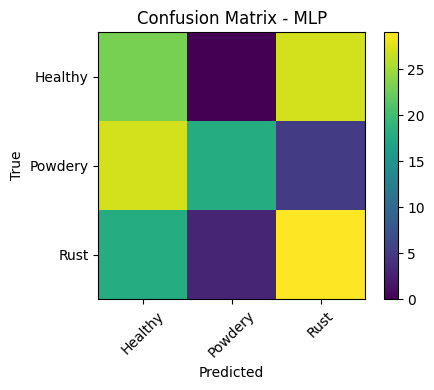

In [44]:
# evaluation du MLP -- QUESTION 6: CONSTRUIRE LA MATRICE DE CONFUSION DE VOTRE MODELE. (HEATMAP OPTIONNELLE,  ON PEUT DONNER LA FONCTION PREDICT ?)
def predict_dataset(model, dataset):
    y_true = []
    y_pred = []
    for batch_images, batch_labels in dataset:
        preds = model.predict(batch_images, verbose=0)
        y_true.extend(batch_labels.numpy().tolist())
        y_pred.extend(np.argmax(preds, axis=1).tolist())
    return np.array(y_true), np.array(y_pred)

y_true_mlp, y_pred_mlp = predict_dataset(mlp, test_ds)

cm_mlp = confusion_matrix(y_true_mlp, y_pred_mlp)
print("Confusion matrix (MLP):\n", cm_mlp)
print("\nClassification report (MLP):\n",
      classification_report(y_true_mlp, y_pred_mlp, target_names=class_names, digits=4))

plt.figure(figsize=(5,4))
plt.imshow(cm_mlp, interpolation="nearest")
plt.title("Confusion Matrix - MLP")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()

In [45]:
# construction CNN -- QUESTION 7 : CONSTRUISEZ A PRESENT UN CNN COMPORTANT QUATRE COUCHES CACHEES QUI COMPRENDRONT 32, 64, 128 ET ENFIN 256 NEURONES. 
# LES COUCHES CACHEES UTILISERONT LA FONCTION D'ACTIVATION RELU ET LA COUCHE DE SORTIE LA FONCTION D'ACTIVATION SOFTMAX. COMPILEZ VOTRE MODELE.

def build_cnn(input_shape, num_classes=3):
    inputs = layers.Input(shape=input_shape)
    x = inputs

    x = layers.Conv2D(32, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(64, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(128, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)
    x = layers.MaxPooling2D()(x)

    x = layers.Conv2D(256, 3, padding="same", use_bias=True)(x)
    x = layers.LayerNormalization(axis=-1)(x)
    x = layers.Activation("relu")(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)

    model = keras.Model(inputs, outputs, name="cnn_layernorm")
    return model

cnn = build_cnn(IMG_SHAPE, 3)

cnn.compile(
    optimizer=keras.optimizers.Adam(3e-4),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

cnn.summary()


Model: "cnn_layernorm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_8           │ (None, 224, 224, 32)   │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_9           │ (None, 112, 112, 64)   │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_10          │ (None, 56, 56, 128)    │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_11          │ (None, 28, 28, 256)    │           512 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 200704)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │       602,115 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 991,491 (3.78 MB)

 Trainable params: 991,491 (3.78 MB)

 Non-trainable params: 0 (0.00 B)

In [46]:
# training CNN -- QUESTION 8 : LANCEZ L'ENTRAINEMENT DE VOTRE MODELE EN PENSANT A SAUVEGARDER L'HISTORIQUE POUR LA SUITE DU TP.
# VOUS POUVEZ PARAMETRER DES CALLBACKS SI NECESSAIRE.

early = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True
)

history_cnn = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early],
    verbose=2
)


Epoch 1/20
20/20 - 21s - 1s/step - accuracy: 0.3175 - loss: 10.7306 - val_accuracy: 0.3333 - val_loss: 6.6055
Epoch 2/20
20/20 - 19s - 936ms/step - accuracy: 0.3810 - loss: 4.0205 - val_accuracy: 0.4500 - val_loss: 1.1616
Epoch 3/20
20/20 - 19s - 939ms/step - accuracy: 0.4238 - loss: 1.6902 - val_accuracy: 0.3500 - val_loss: 1.7115
Epoch 4/20
20/20 - 19s - 951ms/step - accuracy: 0.4921 - loss: 1.1900 - val_accuracy: 0.5833 - val_loss: 1.2029
Epoch 5/20
20/20 - 19s - 948ms/step - accuracy: 0.5873 - loss: 1.0198 - val_accuracy: 0.7000 - val_loss: 0.9413
Epoch 6/20
20/20 - 19s - 950ms/step - accuracy: 0.7302 - loss: 0.6833 - val_accuracy: 0.7167 - val_loss: 0.7989
Epoch 7/20
20/20 - 19s - 948ms/step - accuracy: 0.7651 - loss: 0.5760 - val_accuracy: 0.8333 - val_loss: 0.5261
Epoch 8/20
20/20 - 19s - 947ms/step - accuracy: 0.8222 - loss: 0.4787 - val_accuracy: 0.8500 - val_loss: 0.4656
Epoch 9/20
20/20 - 19s - 946ms/step - accuracy: 0.8619 - loss: 0.3483 - val_accuracy: 0.7667 - val_loss: 0

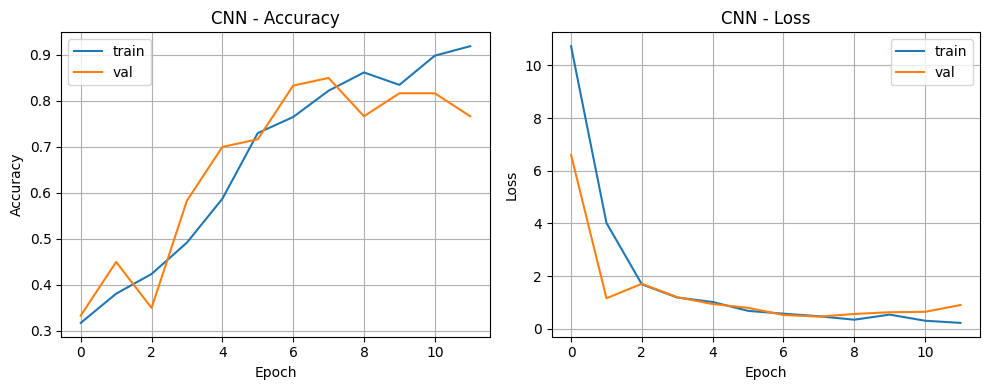

In [47]:
# learning curves -- QUESTION 9 : AFFICHEZ LES COURBES D'APPRENTISSAGE OBTENUES PAR VOTRE MODELE. COMMENTEZ.
plot_history(history_cnn, "CNN")

Confusion matrix (CNN):
 [[38  0 12]
 [ 4 43  3]
 [16  2 32]]

Classification report (CNN):
               precision    recall  f1-score   support

     Healthy     0.6552    0.7600    0.7037        50
     Powdery     0.9556    0.8600    0.9053        50
        Rust     0.6809    0.6400    0.6598        50

    accuracy                         0.7533       150
   macro avg     0.7639    0.7533    0.7563       150
weighted avg     0.7639    0.7533    0.7563       150



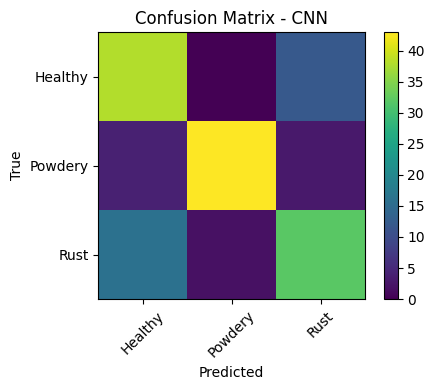

In [48]:
# evaluation du CNN -- QUESTION 10: CONSTRUIRE LA MATRICE DE CONFUSION DE VOTRE MODELE. (HEATMAP OPTIONNELLE,  ON PEUT DONNER LA FONCTION PREDICT ?)
y_true_cnn, y_pred_cnn = predict_dataset(cnn, test_ds)

cm_cnn = confusion_matrix(y_true_cnn, y_pred_cnn)
print("Confusion matrix (CNN):\n", cm_cnn)
print("\nClassification report (CNN):\n",
      classification_report(y_true_cnn, y_pred_cnn, target_names=class_names, digits=4))

plt.figure(figsize=(5,4))
plt.imshow(cm_cnn, interpolation="nearest")
plt.title("Confusion Matrix - CNN"),
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicted"); plt.ylabel("True")
plt.tight_layout(); plt.show()


In [49]:
# comparaison MLP vs CNN -- QUESTION FINALE : COMPAREZ LES RESULTATS DE VOS MODELES. COMMENTEZ.
best_val_acc_mlp = max(history_mlp.history["val_accuracy"])
best_val_acc_cnn = max(history_cnn.history["val_accuracy"])
print(f"Best Val Accuracy - MLP: {best_val_acc_mlp * 100 :.2f}%")
print(f"Best Val Accuracy - CNN: {best_val_acc_cnn * 100 :.2f}%")

Best Val Accuracy - MLP: 61.67%
Best Val Accuracy - CNN: 85.00%


In [50]:
# comparaison MLP vs CNN -- QUESTION COMPLEMENTAIRE : UTILISEZ LE COEFFICIENT DE CORRELATION DE MATTHEWS POUR COMPARER VOS RESULTATS. COMMENTEZ.
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

def predict_labels(model, ds):
    y_pred_list = []
    for x_batch, _ in ds:
        proba = model.predict(x_batch, verbose=0)
        y_pred_list.append(np.argmax(proba, axis=1))
    return np.concatenate(y_pred_list, axis=0)

y_pred_cnn = predict_labels(cnn, test_ds)
y_pred_mlp = predict_labels(mlp, test_ds)

mcc_cnn = matthews_corrcoef(y_true, y_pred_cnn)
mcc_mlp = matthews_corrcoef(y_true, y_pred_mlp)

print(f"MCC CNN : {mcc_cnn:.4f}")
print(f"MCC MLP : {mcc_mlp:.4f}")

2025-12-18 14:04:51.203180: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


MCC CNN : 0.6321
MCC MLP : 0.2092


Nombre d'erreurs : 37


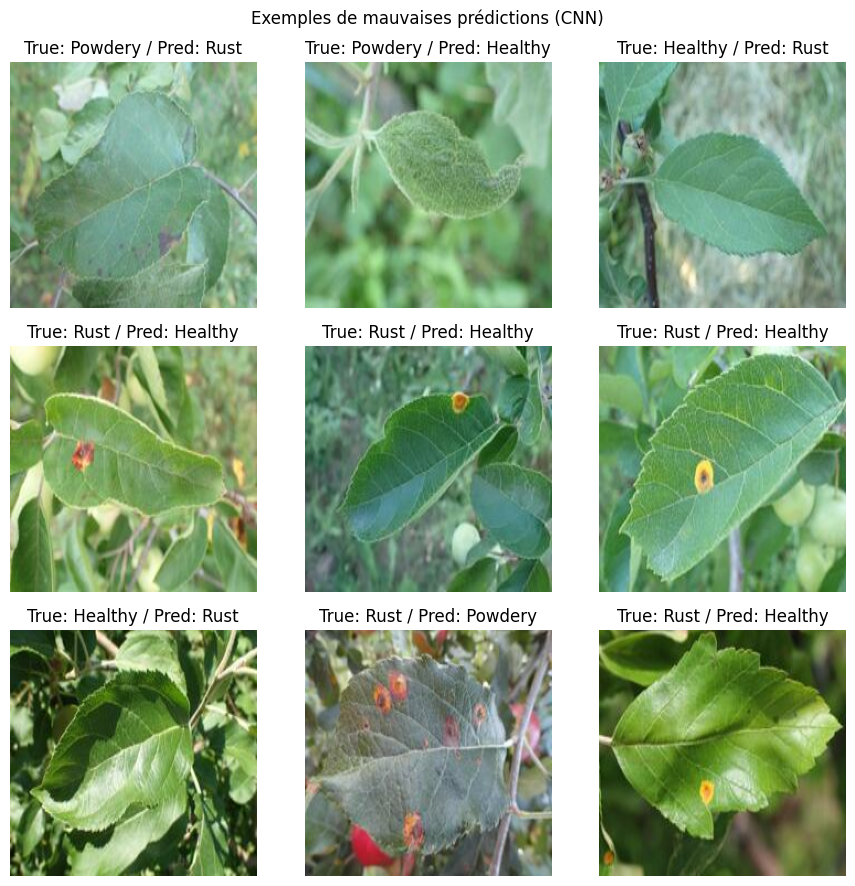

In [52]:
# QUESTION COMPLEMENTAIRE : AFFICHAGE DE QUELQUES ERREURS
errors = np.where(y_true != y_pred_cnn)[0]
print(f"Nombre d'erreurs : {len(errors)}")

np.random.seed(42)
sample_errors = np.random.choice(errors, size=min(9, len(errors)), replace=False)

X_test = np.concatenate([x.numpy() for x, _ in test_ds], axis=0)

plt.figure(figsize=(9, 9))

for i, idx in enumerate(sample_errors):
    plt.subplot(3, 3, i + 1)
    plt.imshow(X_test[idx])
    plt.axis("off")
    true_name = class_names[int(y_true[idx])]
    pred_name = class_names[int(y_pred_cnn[idx])]
    plt.title(f"True: {true_name} / Pred: {pred_name}")

plt.suptitle("Exemples de mauvaises prédictions (CNN)")
plt.tight_layout()
plt.show()
